In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from window import HanningWindow, KBDWindow, SineWindow
from psychoac import SPL, Thresh

In [2]:
def get_x(N, Fs):
    n_array = np.arange(N)
    x = (
        0.40 * np.cos(2 * np.pi * 220 * n_array / Fs)
        + 0.24 * np.cos(2 * np.pi * 330 * n_array / Fs)
        + 0.18 * np.cos(2 * np.pi * 440 * n_array / Fs)
        + 0.08 * np.cos(2 * np.pi * 880 * n_array / Fs)
        + 0.04 * np.cos(2 * np.pi * 4400 * n_array / Fs)
        + 0.02 * np.cos(2 * np.pi * 8800 * n_array / Fs)
    )
    return x

In [3]:
# 1.c)
from mdct import MDCT
from psychoac import (
    AssignMDCTLinesFromFreqLimits,
    ScaleFactorBands,
    getMaskedThreshold,
    intensity_from_DFT,
    intensity_from_MDCT,
    CalcSMRs,
    cbFreqLimits,
)
from quantize import ScaleFactor

N = 1024
nMDCTLines = N // 2
sampleRate = 48000
data = get_x(N, sampleRate)
nLines = AssignMDCTLinesFromFreqLimits(nMDCTLines, sampleRate)
# print(nLines.cumsum())
sfBands = ScaleFactorBands(nLines)

# MDCT: use KBDWindow
data_windowed = KBDWindow(data)
MDCTdata = MDCT(data_windowed, nMDCTLines, nMDCTLines)

# calculate masked threshold etc.
masked_thresh = getMaskedThreshold(data, None, None, sampleRate, sfBands)
freq_array = np.arange(N // 2) / N * sampleRate
quiet_thresh = Thresh(freq_array)
DFTspl = SPL(intensity_from_DFT(scipy.fft.rfft(HanningWindow(data))[:-1]))
MDCTspl = SPL(intensity_from_MDCT(MDCTdata))
MDCTspl_sfb = np.array(
    [
        np.max(MDCTspl[sfBands.lowerLine[i] : sfBands.upperLine[i] + 1])
        for i in range(sfBands.nBands)
    ]
)

sfb_array = np.concat(([0], cbFreqLimits, [24000]))


# hard-coded bit allocation array
# uniform
def bitalloc_uniform(target_mantissa):
    mt_avg = target_mantissa / nMDCTLines
    lo = int(np.floor(mt_avg))
    hi = int(np.ceil(mt_avg))
    # lo * x + hi * (nMDCTLines - x) = target_mantissa
    # (hi - lo) x = hi * nMDCTLines - target_mantissa
    x = int(np.round((hi * nMDCTLines - target_mantissa) / (hi - lo)))
    y = nMDCTLines - x
    print("noise floor i")
    print(sfBands.nLines.cumsum())
    idx = np.searchsorted(sfBands.nLines.cumsum(), y, side="right")
    print(idx)
    mt_uniform = np.concat((np.ones(idx) * hi, np.ones(25 - idx) * lo))
    nf_uniform = np.array(MDCTspl_sfb)
    nf_uniform[:idx] -= 6 * hi
    nf_uniform[idx:] -= 6 * lo
    print(mt_uniform.astype(int))
    print(np.sum(mt_uniform * sfBands.nLines))
    return mt_uniform, nf_uniform


def bitalloc_constNF(target_mantissa):
    # constant noise floor
    print("noise floor ii")
    target_area = target_mantissa * 6
    lo = np.min(MDCTspl_sfb)
    hi = np.max(MDCTspl_sfb)

    tol = 1e-6  # tolerance for stopping
    while hi - lo > tol:
        mid = (lo + hi) / 2
        # Compute the area: sum up (SPL - mid) wherever SPL is above mid.
        area = np.sum(np.maximum(MDCTspl_sfb - mid, 0) * sfBands.nLines)
        if area > target_area:
            lo = mid
        else:
            hi = mid

    nf_const_c = (lo + hi) / 2
    print(nf_const_c)
    mt_const = np.maximum((MDCTspl_sfb - nf_const_c) / 6, 0)
    # print(mt_const)
    mt_const = np.round(mt_const, decimals=0)
    print(mt_const)
    print(get_total_bits(mt_const))
    nf_const = get_nf(mt_const)
    return mt_const, nf_const


def bitalloc_NMR(target_mantissa):
    # constant distance below the masked threshold curve
    print("noise floor iii")
    masked_thresh_sfb = np.array(
        [
            np.average(masked_thresh[sfBands.lowerLine[i] : sfBands.upperLine[i] + 1])
            for i in range(sfBands.nBands)
        ]
    )
    target_area = target_mantissa * 6
    lo = -200
    hi = 200

    tol = 1e-6  # tolerance for stopping
    while hi - lo > tol:
        mid = (lo + hi) / 2  # this is the distance from the masked threshold
        nf = masked_thresh_sfb + mid  # an array of subbands
        # Compute the area: sum up (SPL - mid) wherever SPL is above mid.
        area = np.sum(np.maximum(MDCTspl_sfb - nf, 0) * sfBands.nLines)
        if area > target_area:
            lo = mid
        else:
            hi = mid

    mid = (lo + hi) / 2
    print(mid)
    nf_nmr = masked_thresh_sfb + mid
    mt_nmr = (MDCTspl_sfb - nf_nmr) / 6
    mt_nmr = np.maximum(mt_nmr, 0)
    mt_nmr = np.round(mt_nmr, decimals=0)
    print(mt_nmr)
    print(get_total_bits(mt_nmr))
    nf_nmr = get_nf(mt_nmr)
    return mt_nmr, nf_nmr


def get_nf(mt):
    return MDCTspl_sfb - mt * 6


def get_total_bits(mt):
    return np.sum(mt * sfBands.nLines)


# plot
def extended(x):
    # for step plotting, prepend the first value
    return np.insert(x, 0, x[0])


noise floor i
[  3   5   7   9  11  14  17  20  24  28  32  37  43  50  58  68  79  94
 114 137 165 203 256 331 512]
20
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2]
1161.0
noise floor ii
-8.02569024296066
[13. 16. 14. 15. 15. 12. 11. 14.  8.  3.  1.  1.  1.  1.  0.  0.  0. 10.
 12.  0.  0. 11.  0.  0.  0.]
1144.0
noise floor iii
-50.18616206943989
[10. 11.  8.  9. 10.  8.  8. 10.  5.  2.  3.  4.  6.  7.  8.  6.  1.  8.
 10.  0.  0. 10.  0.  0.  0.]
1164.0
BY HAND...
[13 16 14 15 15 12 11 14  8  3  2  2  2  0  0  0  0 10 12  0  0 11  0  0
  0]
1152
[10 11  8  9 10  8  8 10  5  2  3  4  6  7  8  6  0  8 10  0  0 10  0  0
  0]
1153


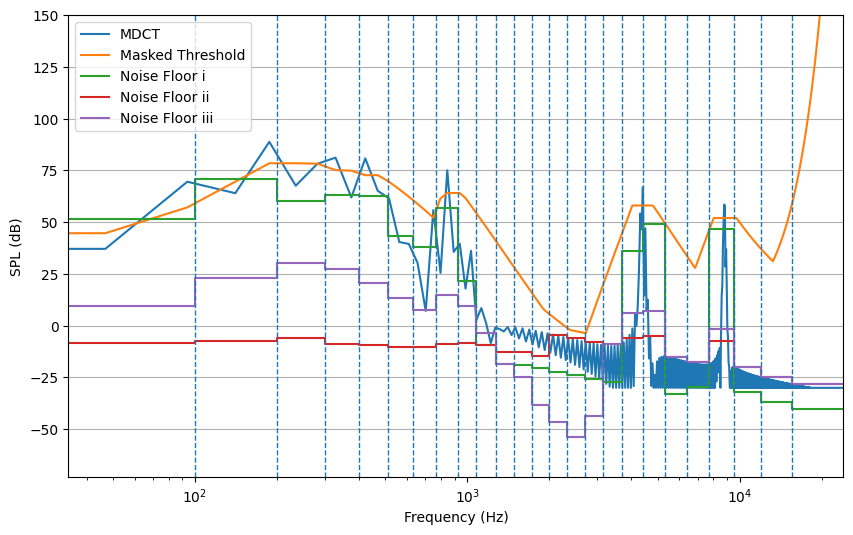

In [4]:
target_mantissa = 1161
mt_uniform, nf_uniform = bitalloc_uniform(target_mantissa)
mt_const, nf_const = bitalloc_constNF(target_mantissa)
mt_nmr, nf_nmr = bitalloc_NMR(target_mantissa)

print("BY HAND...")
mt_const = np.array([13, 16, 14, 15, 15, 12, 11, 14,  8,  3,  2,  2,  2,  0,  0,  0,  0, 10, 12,  0,  0, 11,  0,  0,  0])  # fmt:off
nf_const = get_nf(mt_const)
print(mt_const)
print(get_total_bits(mt_const))
mt_nmr = np.array([10, 11,  8,  9, 10,  8,  8, 10,  5,  2,  3,  4,  6,  7,  8,  6,  0,  8, 10,  0,  0, 10,  0,  0,  0])  # fmt:off
nf_nmr = get_nf(mt_nmr)
print(mt_nmr)
print(get_total_bits(mt_nmr))

plt.figure(figsize=(10, 6))
# plt.plot(freq_array, DFTspl, label="DFT Signal")
plt.plot(freq_array, MDCTspl, label="MDCT")
# plt.plot(freq_array, quiet_thresh, label="Threshold in quiet")
# plt.step(sfb_array, extended(MDCTspl_sfb), label="MDCT Peaks")
plt.plot(freq_array, masked_thresh, label="Masked Threshold")
plt.step(sfb_array, extended(nf_uniform), label="Noise Floor i")
plt.step(sfb_array, extended(nf_const), label="Noise Floor ii")
# plt.step(sfb_array, extended(masked_thresh_sfb), label="Masked Threshold (avg)")
plt.step(sfb_array, extended(nf_nmr), label="Noise Floor iii")
for f in cbFreqLimits:
    plt.axvline(f, linestyle="--", linewidth=1)
plt.xscale("log")
plt.xlim(right=24000)
plt.ylim(top=150)
plt.xlabel("Frequency (Hz)")
plt.ylabel("SPL (dB)")

plt.grid(axis="y")
plt.legend()
plt.show()

noise floor i
[  3   5   7   9  11  14  17  20  24  28  32  37  43  50  58  68  79  94
 114 137 165 203 256 331 512]
23
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3]
1792.0
noise floor ii
-27.4871898323511
[16. 19. 18. 18. 18. 15. 14. 17. 11.  6.  4.  4.  4.  4.  4.  3.  3. 14.
 16.  2.  2. 14.  1.  0.  0.]
1800.0
noise floor iii
-68.88041086494923
[13. 14. 11. 13. 13. 11. 12. 13.  8.  5.  6.  8.  9. 10. 11.  9.  5. 11.
 13.  2.  3. 13.  1.  1.  0.]
1899.0
BY HAND...
[16 16 16 16 16 15 14 16 11  6  4  4  5  4  4  3  3 14 16  2  2 14  2  0
  0]
1838
[13 14 11 13 13 11 12 13  8  5  6  8  9 10 11  9  5 11 13  2  3 12  2  0
  0]
1839


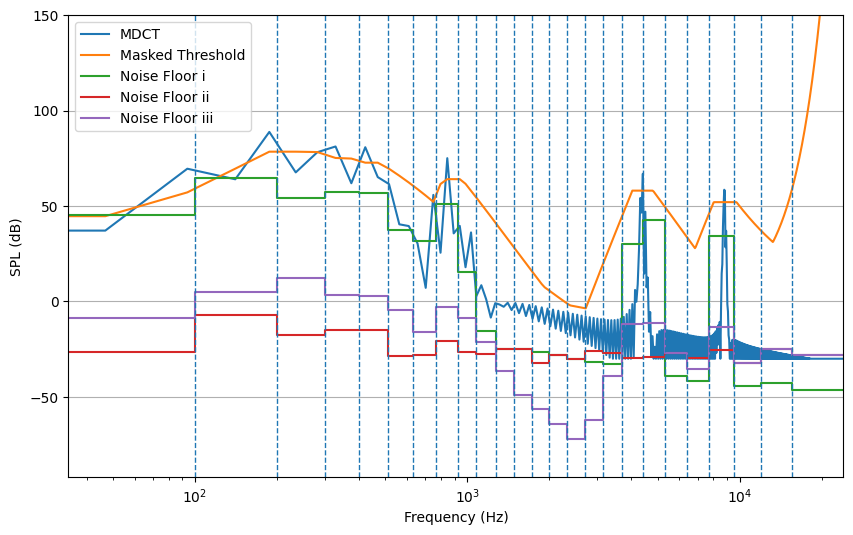

In [5]:
# 1.d)
target_mantissa = 1844
mt_uniform, nf_uniform = bitalloc_uniform(target_mantissa)
mt_const, nf_const = bitalloc_constNF(target_mantissa)
mt_nmr, nf_nmr = bitalloc_NMR(target_mantissa)

print("BY HAND...")
mt_const = np.array([16, 16, 16, 16, 16, 15, 14, 16, 11,  6,  4,  4,  5,  4,  4,  3,  3, 14, 16,  2,  2, 14,  2,  0,  0])  # fmt:off
nf_const = get_nf(mt_const)
print(mt_const)
print(get_total_bits(mt_const))
mt_nmr = np.array([13, 14, 11, 13, 13, 11, 12, 13,  8,  5,  6,  8,  9, 10, 11,  9,  5, 11, 13,  2,  3, 12,  2,  0,  0])  # fmt:off
nf_nmr = get_nf(mt_nmr)
print(mt_nmr)
print(get_total_bits(mt_nmr))

plt.figure(figsize=(10, 6))
# plt.plot(freq_array, DFTspl, label="DFT Signal")
plt.plot(freq_array, MDCTspl, label="MDCT")
# plt.plot(freq_array, quiet_thresh, label="Threshold in quiet")
# plt.step(sfb_array, extended(MDCTspl_sfb), label="MDCT Peaks")
plt.plot(freq_array, masked_thresh, label="Masked Threshold")
plt.step(sfb_array, extended(nf_uniform), label="Noise Floor i")
plt.step(sfb_array, extended(nf_const), label="Noise Floor ii")
# plt.step(sfb_array, extended(masked_thresh_sfb), label="Masked Threshold (avg)")
plt.step(sfb_array, extended(nf_nmr), label="Noise Floor iii")
for f in cbFreqLimits:
    plt.axvline(f, linestyle="--", linewidth=1)
plt.xscale("log")
plt.xlim(right=24000)
plt.ylim(top=150)
plt.xlabel("Frequency (Hz)")
plt.ylabel("SPL (dB)")

plt.grid(axis="y")
plt.legend()
plt.show()


[ 24.435  22.391  11.946  18.049  20.132   4.01   15.675  23.03   -9.774
 -30.24  -21.335  -7.447   2.027   6.283   7.923   7.818 -19.186   8.205
  20.896 -39.261 -34.102  18.549 -50.216 -45.445 -75.323]
[11 11  9 10  9  7  9 10  5  2  3  5  6  7  7  7  3  8 10  0  0  9  0  0
  0]
1160
[14 13 11 12 12 10 12 13  7  4  5  8  9 10 10 10  6 10 12  2  3 12  0  2
  0]
1843


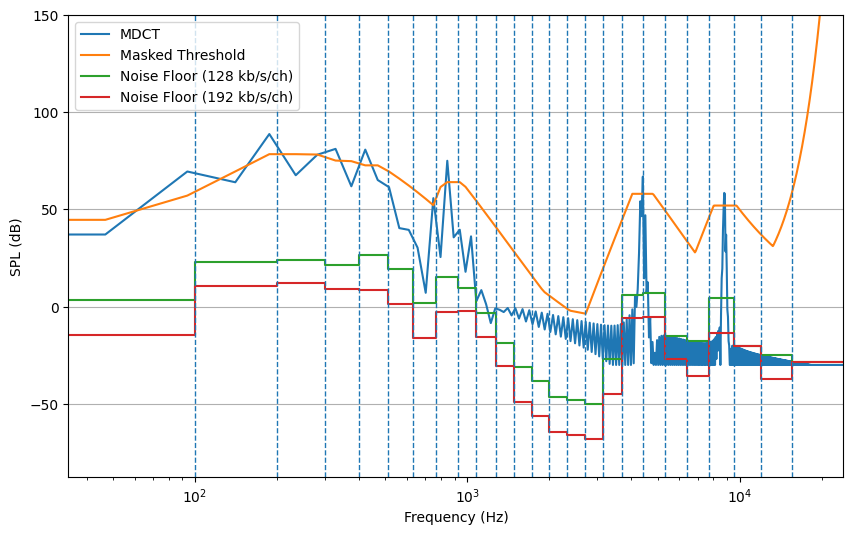

In [7]:
# 2.b)

from bitalloc import BitAlloc

# get SMR
MDCT_maxMagnitude = np.max(np.abs(MDCTdata))
MDCTscale = ScaleFactor(MDCT_maxMagnitude)
MDCTdata = MDCTdata * (2**MDCTscale)
SMRs = CalcSMRs(data, MDCTdata, MDCTscale, sampleRate, sfBands)
print(np.around(SMRs, decimals=3))


plt.figure(figsize=(10, 6))
plt.plot(freq_array, MDCTspl, label="MDCT")
plt.plot(freq_array, masked_thresh, label="Masked Threshold")
mt = BitAlloc(1161, 16, 25, nLines, SMRs)
print(mt)
print(get_total_bits(mt))
nf = get_nf(mt)
plt.step(sfb_array, extended(nf), label="Noise Floor (128 kb/s/ch)")
mt = BitAlloc(1844, 16, 25, nLines, SMRs)
print(mt)
print(get_total_bits(mt))
nf = get_nf(mt)
plt.step(sfb_array, extended(nf), label="Noise Floor (192 kb/s/ch)")
for f in cbFreqLimits:
    plt.axvline(f, linestyle="--", linewidth=1)
plt.xscale("log")
plt.xlim(right=24000)
plt.ylim(top=150)
plt.xlabel("Frequency (Hz)")
plt.ylabel("SPL (dB)")

plt.grid(axis="y")
plt.legend()
plt.show()